In [1]:
# Import required packages/modules
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from random import sample
import math
from itertools import chain
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from sklearn.utils import shuffle

In [2]:
# Set working directory and import csv
# os.chdir("C:/Users/LynchZ20/Desktop/Courses/MSDS/SY_S2/ML/FinalProject/COVID19_DeepLearning/")
dd = pd.read_csv("final.csv")

# Add field for county-state combo as there are duplicate counties in the dataset
dd['county_state'] = dd['county'].map(str) + '-' + dd['state'].map(str)
dd['county_state'] = dd['county_state'].str.replace("\'","")

In [3]:
# Look at summary info
dd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81772 entries, 0 to 81771
Data columns (total 8 columns):
date            81772 non-null object
county          81772 non-null object
state           81772 non-null object
cases           81772 non-null int64
deaths          81772 non-null int64
type            71701 non-null object
SAH             81772 non-null int64
county_state    81772 non-null object
dtypes: int64(3), object(5)
memory usage: 5.0+ MB


In [31]:
# Initialize dataframe and number of days to keep for RNN
trend_df = pd.DataFrame(columns={"cases_trend","deaths_trend", "SAH"})
trend_list = []
days_in_sequence = 20
reverse = True

# Churn through each county and create a row for each day with the previous 14 days of data
for county in dd.county_state.unique():
    county_df = dd.query(f"county_state=='{county}'")
            
    # Make strides of 1, and ignore padding on both ends at this point
    for i in range(0,len(county_df)):
        if i+days_in_sequence<=len(county_df):

            if reverse:
                #Prepare list of cases and deaths
                cases_trend = [float(x) for x in county_df[-i-days_in_sequence:-1-i].cases.values]
                deaths_trend = [float(x) for x in county_df[-i-days_in_sequence:-1-i].deaths.values]

                #Add response value
                SAH = float(county_df.iloc[-i-days_in_sequence].SAH)
            else:
                cases_trend = [float(x) for x in county_df[i:i+days_in_sequence-1].cases.values]
                deaths_trend = [float(x) for x in county_df[i:i+days_in_sequence-1].deaths.values]
                SAH = float(county_df.iloc[i+days_in_sequence-1].SAH)

            trend_list.append({"cases_trend":np.asarray(cases_trend),
                                "deaths_trend":np.asarray(deaths_trend),
                                "SAH":SAH})
trend_df = pd.DataFrame(trend_list)

In [32]:
# Prepare RNN input
trend_df["inputs"] = [np.asarray([trends["cases_trend"],trends["deaths_trend"]]) for idx,trends in trend_df.iterrows()]
trend_df = shuffle(trend_df)

In [33]:
# Set up train/test split
sequence_length = days_in_sequence - 1
training_percentage = 0.7

# Perform train/test split
training_item_count = int(len(trend_df)*training_percentage)
validation_item_count = len(trend_df)-int(len(trend_df)*training_percentage)
training_df = trend_df[:training_item_count]
validation_df = trend_df[training_item_count:]

In [34]:
# Prepare train sets
X_train = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in training_df["inputs"].values]),(training_item_count,2,sequence_length)),(0,2,1) )).astype(np.float32)
Y_train = np.asarray([np.asarray(x) for x in training_df["SAH"]]).astype(np.float32)

# Prepare test sets
X_test = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in validation_df["inputs"].values]),(validation_item_count,2,sequence_length)),(0,2,1) )).astype(np.float32)
Y_test = np.asarray([np.asarray(x) for x in validation_df["SAH"]]).astype(np.float32)

In [35]:
# design network
model = models.Sequential()
model.add(layers.LSTM(50, input_shape=(X_test.shape[1], X_train.shape[2])))
model.add(layers.Dense(1, activation='sigmoid'))

In [36]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
history = model.fit(X_train, Y_train,
                    epochs=10,
                    batch_size=25,
                    validation_data=(X_test, Y_test)
                   )

Train on 21799 samples, validate on 9343 samples
Epoch 1/10
21799/21799 [==============================] - 9s 390us/sample - loss: 0.6179 - accuracy: 0.6613 - val_loss: 0.5979 - val_accuracy: 0.6741
Epoch 2/10
21799/21799 [==============================] - 7s 304us/sample - loss: 0.5914 - accuracy: 0.6770 - val_loss: 0.5899 - val_accuracy: 0.6729
Epoch 3/10
21799/21799 [==============================] - 6s 256us/sample - loss: 0.5862 - accuracy: 0.6792 - val_loss: 0.5800 - val_accuracy: 0.6823
Epoch 4/10
21799/21799 [==============================] - 6s 258us/sample - loss: 0.5834 - accuracy: 0.6827 - val_loss: 0.5869 - val_accuracy: 0.6814
Epoch 5/10
21799/21799 [==============================] - 6s 257us/sample - loss: 0.5811 - accuracy: 0.6829 - val_loss: 0.5793 - val_accuracy: 0.6825
Epoch 6/10
21799/21799 [==============================] - 5s 252us/sample - loss: 0.5802 - accuracy: 0.6804 - val_loss: 0.5763 - val_accuracy: 0.6849
Epoch 7/10
21799/21799 [===========================

In [38]:
sum(Y_test)/len(Y_test)

0.4052231617253559

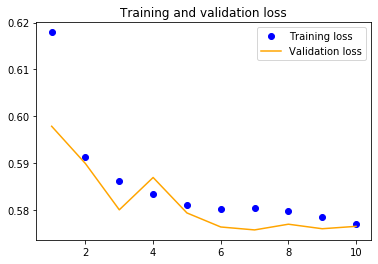

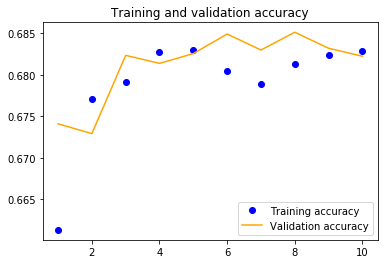

In [39]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()